## Pedestal and channel-by-channel threshold

In [1]:
import h5py
import uproot
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Configurations from calib_prompt_hits
vref_mv = 1568.0 # mV
vcm_mv = 478.1 # mV
adc_counts = 256
gain = 4.522 # mV /ke-
pedestal_mv = 580.0 # mV

In [3]:
os.listdir('threshold_ped_data')

['reference-cold-pedestal-2024_06_05_08_28_19_CDT.h5',
 'packet-2024_06_28_08_51_52_CDT.h5']

In [4]:
thr_file = h5py.File("threshold_ped_data/packet-2024_06_28_08_51_52_CDT.h5", 'r')
thr_file.keys()

<KeysViewHDF5 ['_header', 'configs', 'daq_configs', 'messages', 'packets']>

In [5]:
np.unique(thr_file['packets']['io_group'])

array([1, 2, 3, 4, 5, 6, 7, 8], dtype=uint8)

In [6]:
ped_file = h5py.File("threshold_ped_data/reference-cold-pedestal-2024_06_05_08_28_19_CDT.h5", 'r')
ped_file.keys()

<KeysViewHDF5 ['_header', 'configs', 'messages', 'packets']>

### Getting the threshold and pedestal

In [10]:
def get_packet_dataset(rawdata, io_groups=[0, 1]):
    # From Brooke's code
    # tested on threshold data
    io_group_mask = ((rawdata['packets']['io_group']==io_groups[0])|(rawdata['packets']['io_group']==io_groups[1])) # select one packet
    packets_data = rawdata['packets'][io_group_mask]
    sync_mask = ((packets_data['packet_type']==6)&((packets_data['trigger_type']==83)|((packets_data['trigger_type']==72)|((packets_data['trigger_type']==2))))) # Select SYNC packets that are externally generated
    sync_idcs = np.argwhere(sync_mask).flatten()
    message_groups = np.split(packets_data, sync_idcs) # partition the packet dataset by sync packet index
    print(len(message_groups), 'packet groups partitioned by sync packets')
    return message_groups

def charge_from_dataword(dw, vref, vcm, ped, adc_counts, gain):
    return ((dw/adc_counts)*(vref-vcm) + vcm - ped) / gain

In [175]:
def _plot(sync_group, message_groups_thr, message_groups_ped, chn=-1):
    mg = message_groups_thr[sync_group]
    mg_ped = message_groups_ped[sync_group]

    if chn!=-1:
        data_mask = ((mg['packet_type']==0)&(mg['valid_parity']==1)&(mg['timestamp']<1e7)&(mg['channel_id']==chn)) # filter on data packets with valid parity with sync-consistent timestamp
        data_mask_ped = ((mg_ped['packet_type']==0)&(mg_ped['valid_parity']==1)&(mg_ped['timestamp']<1e7)&(mg_ped['channel_id']==chn))
    else:
        data_mask = ((mg['packet_type']==0)&(mg['valid_parity']==1)&(mg['timestamp']<1e7)) # filter on data packets with valid parity with sync-consistent timestamp
        data_mask_ped = ((mg_ped['packet_type']==0)&(mg_ped['valid_parity']==1)&(mg_ped['timestamp']<1e7))
    data_packets_thr = mg[data_mask]
    print(len(data_packets_thr), ' data packets between syncs.')
    data_packets_ped = mg_ped[data_mask_ped]
    print(len(data_packets_ped), ' data packets between syncs.')

    charge_thr = charge_from_dataword(dw=data_packets_thr['dataword'], vref=vref_mv, vcm=vcm_mv, ped=pedestal_mv, adc_counts=adc_counts, gain=gain)
    charge_ped = charge_from_dataword(dw=data_packets_ped['dataword'], vref=vref_mv, vcm=vcm_mv, ped=pedestal_mv, adc_counts=adc_counts, gain=gain)

    # charge_thr = charge_thr - charge_ped
    # histogram
    # counts, xbins = np.histogram(data_packets['dataword'], bins=128)
    counts, xbins = np.histogram(charge_thr, bins=128)
    counts_ped, xbins_ped = np.histogram(charge_ped, bins=128)
    # c = counts - counts_ped
    # x = xbins - xbins_ped
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    # ax.plot(np.array(xbins[1:]), np.array(counts), '.-')
    ax.stairs(values=counts, edges=xbins, baseline=-1)
    ax.stairs(values=counts_ped, edges=xbins_ped, baseline=-1)
    # ax.set_xlabel('dataword [ADC]')
    # ax.set_xlabel('Charge (ke-)')
    # ax.set_ylabel('count')
    plt.grid(True)
    plt.legend()
    # ax.set_xlim([0,30])
    plt.show()

In [177]:
message_groups_m0_thr = get_packet_dataset(rawdata=thr_file, io_groups=[5,-1])
message_groups_m0_ped = get_packet_dataset(rawdata=ped_file, io_groups=[5,-1])
message_groups_m1 = get_packet_dataset(rawdata=thr_file, io_groups=[3,4])
message_groups_m2 = get_packet_dataset(rawdata=thr_file, io_groups=[5,6])
message_groups_m3 = get_packet_dataset(rawdata=thr_file, io_groups=[7,8])

659 packet groups partitioned by sync packets
329 packet groups partitioned by sync packets


In [178]:

_plot(sync_group=481, message_groups_thr=message_groups_m0_thr, message_groups_ped=message_groups_m0_ped)

IndexError: list index out of range

99384  data packets between syncs.


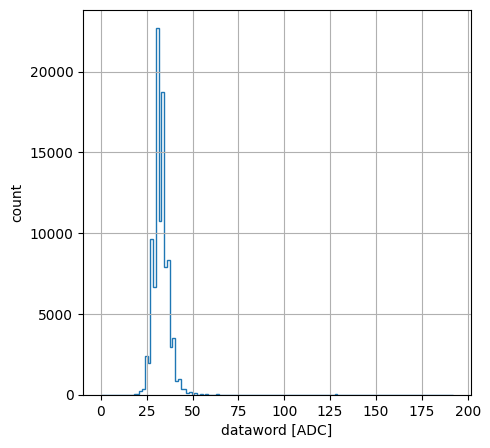

In [38]:
_plot(sync_group=481, message_groups=message_groups_m1)

296012  data packets between syncs.


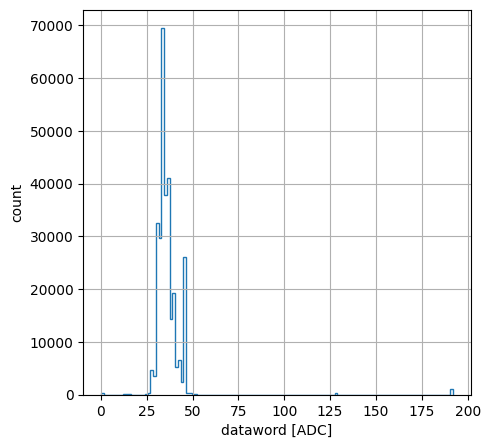

In [40]:
_plot(sync_group=481, message_groups=message_groups_m2)

50024  data packets between syncs.


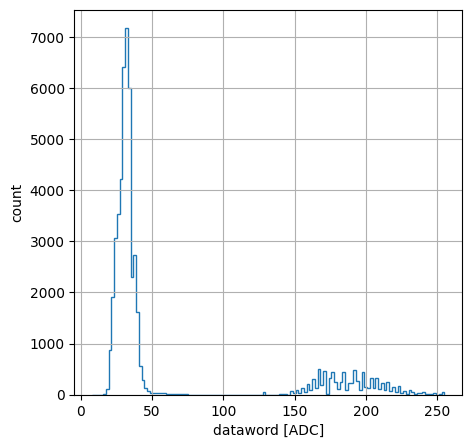

In [50]:
_plot(sync_group=481, message_groups=message_groups_m3)

In [116]:
def _plot_allmodules(sync_group, message_groups_data=[], chn=-1):
    fig, ax = plt.subplots(1,1, figsize=(5,5))
    for img, message_groups in enumerate(message_groups_data):
        mg = message_groups[sync_group]
        if chn!=-1:
            data_mask = ((mg['packet_type']==0)&(mg['valid_parity']==1)&(mg['timestamp']<1e7)&(mg['channel_id']==chn)) # filter on data packets with valid parity with sync-consistent timestamp
        else:
            data_mask = ((mg['packet_type']==0)&(mg['valid_parity']==1)&(mg['timestamp']<1e7)) # filter on data packets with valid parity with sync-consistent timestamp
        data_packets = mg[data_mask]
        print(len(data_packets), ' data packets between syncs in Module {}.'.format(img))

        # histogram
        counts, xbins = np.histogram(data_packets['dataword'], bins=85)
        # ax.plot(np.array(xbins[1:]), np.array(counts), '.-')
        ax.stairs(values=counts, edges=xbins, baseline=-1, label='Module {}'.format(img))
    ax.set_xlabel('dataword [ADC]')
    ax.set_ylabel('count')
    plt.grid(True)
    plt.legend()
    # ax.set_xlim([100,256])
    # ax.set_ylim([0, 2000])
    plt.show()

15276  data packets between syncs in Module 0.
99384  data packets between syncs in Module 1.
296012  data packets between syncs in Module 2.
50024  data packets between syncs in Module 3.


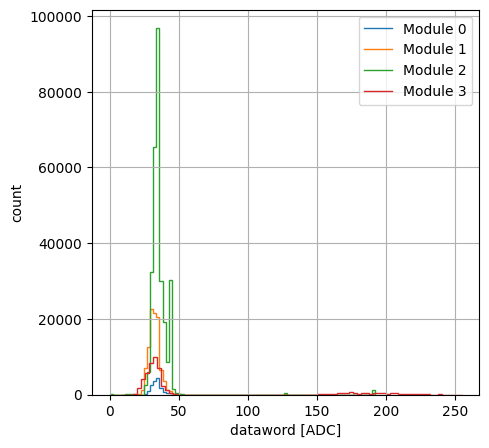

In [117]:
_plot_allmodules(sync_group=481, message_groups_data=[message_groups_m0, message_groups_m1, message_groups_m2, message_groups_m3])

* **Each dataword corresponds to a channel_id $\Rightarrow$ Count in the plot represents the channel count.**
* **Why is the total number not equal to the channel count reported in the 2x2 notes?**
* **How to convert the ADC dataword to charge ?**

In [140]:
# get channel-by-channel threshold for module 2
64-len(np.unique(message_groups_m0[481]['channel_id']))
def _plotCHbyCH(sync_group, message_groups):
    mg = message_groups[sync_group]
    CH_unique = np.unique(mg['channel_id'])
    fig, ax = plt.subplots(1,1, figsize=(15,15))
    for chn in CH_unique:
        data_mask = ((mg['packet_type']==0)&(mg['valid_parity']==1)&(mg['timestamp']<1e7)&(mg['channel_id']==chn)) # filter on data packets with valid parity with sync-consistent timestamp
        data_packets = mg[data_mask]
        # print(len(data_packets), ' data packets between syncs.')

        # histogram
        counts, xbins = np.histogram(data_packets['dataword'], bins=128)
    
        ax.stairs(values=counts, edges=xbins, baseline=-1, label='CH{}'.format(chn))
    ax.set_xlabel('dataword [ADC]')
    ax.set_ylabel('count')
    plt.grid(True)
    plt.legend()
    # ax.set_xlim([0,100])
    plt.show()

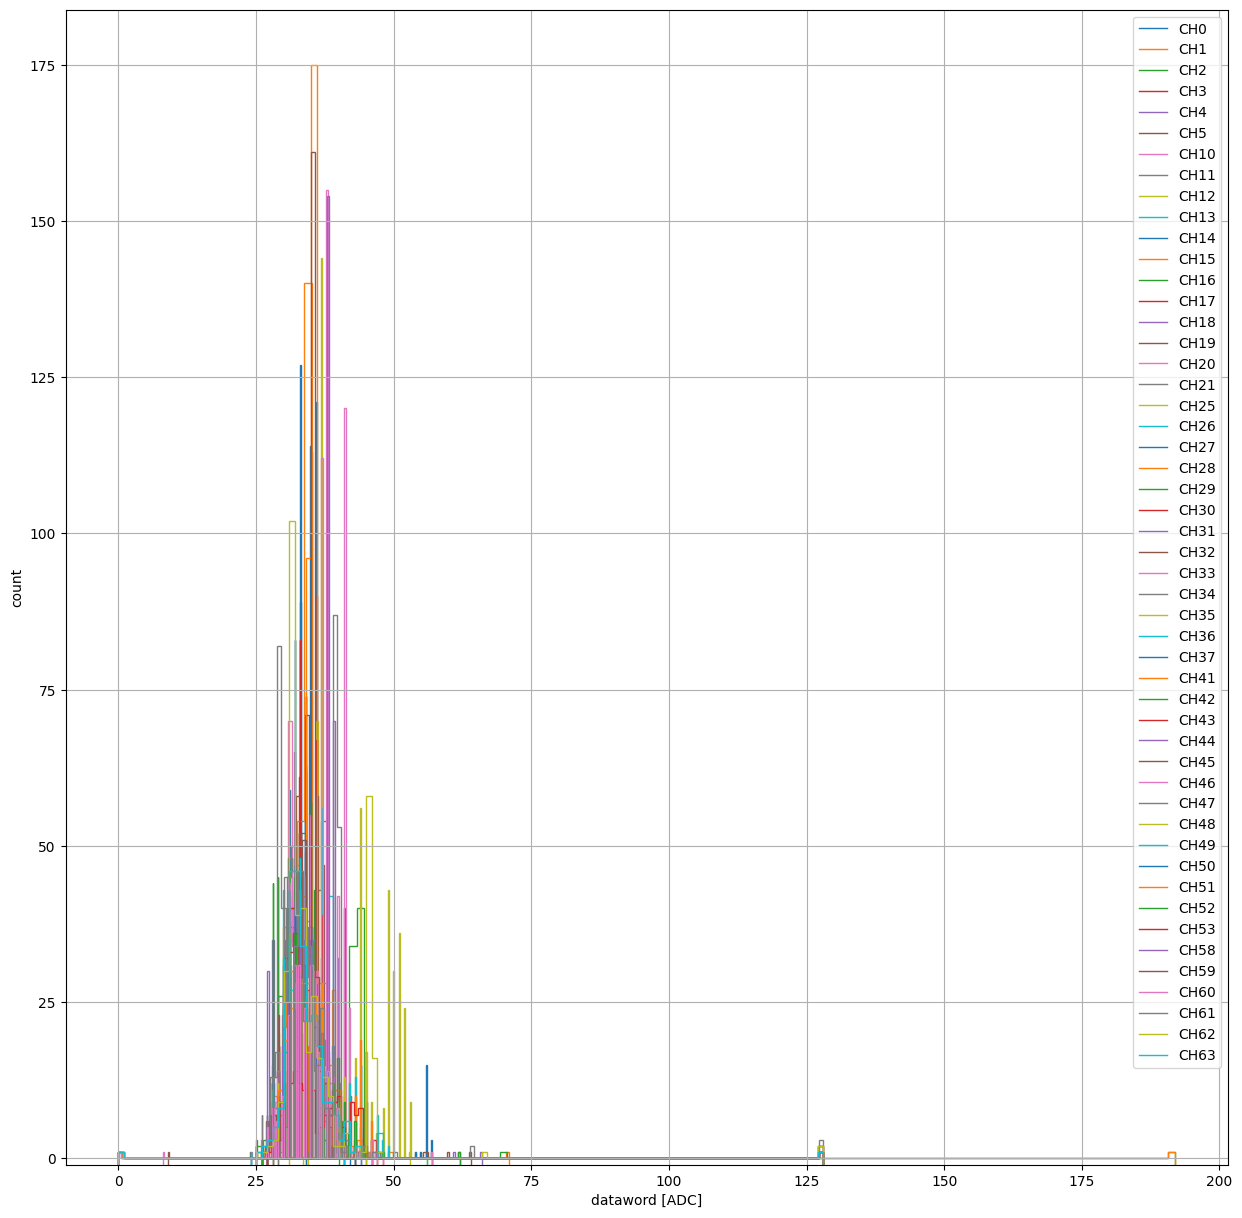

In [141]:
_plotCHbyCH(sync_group=481, message_groups=message_groups_m0)